# Introduction
This python notebook will be used for testing out the NZN parameter sets

## Importing functions and parameter sets

In [1]:
from besos.parameters import wwr, RangeParameter, FieldSelector, FilterSelector, GenericSelector, Parameter, expand_plist
from besos.parameters import RangeParameter, CategoryParameter, expand_plist

from besos import eppy_funcs as ef
import besos.sampling as sampling
from besos.evaluator import EvaluatorEP
from besos.problem import EPProblem

import copy
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt

In [2]:
import os
import sys

#importing a pre-existing parameter set database
nzn_pathway='./parameter_set'
sys.path.append(nzn_pathway)

from architectural_parameters import architectural_parameters
# from comfort_parameters import comfort_parameters
from envelope_parameters import envelope_parameters
# from lighting_parameters import lighting_parameters
# from loads_parameters import loads_parameters
# from plant_parameters import heating_plant_parameters
# from plant_parameters import cooling_plant_parameters
# from renewable_parameters import renewable_parameters
# from system_parameters import system_parameters
# from system_parameters import FCU_parameters
# from system_parameters import VAV_parameters
# from system_parameters import CB_parameters

In [3]:
parameters=[]
defaults={}
inputs_metadata=[]

parameter_sets=[architectural_parameters,envelope_parameters]

for i in parameter_sets:
    parameters.extend(i()[0])
    defaults.update(i()[1])
    inputs_metadata.extend(i()[2])

/home/user/.local/lib/python3.7/site-packages/besos/parameters.py:425: FutureWarning: Use value_descriptors instead of value_descriptor.
  FutureWarning("Use value_descriptors instead of value_descriptor.")


In [4]:
# inputs_metadata

In [5]:
import NZN_output_set
from NZN_output_set import fuel_use
from NZN_output_set import end_use_breakdown
from NZN_output_set import metrics

In [6]:
outputs, outputs_metadata = fuel_use()
outputs1, outputs_metadata1 = end_use_breakdown()
outputs2, outputs_metadata2 = metrics()

outputs = outputs+outputs1+outputs2
outputs_metadata = outputs_metadata+outputs_metadata1+outputs_metadata2

In [7]:
len(outputs_metadata)

24

In [8]:
# Drop any metadata associated with dropped outputs (reference Sampling notebook to confirm which outputs to drop - they must match)

def remove_output_metadata(removed_output_metadata_list, output_metadata_list):
    for label in removed_output_metadata_list:
        for metadata in output_metadata_list:
            if metadata['Label'] == ("{} (ekWh/m2)".format(label)):
                print(label)
                output_metadata_list.remove(metadata)
            
    return output_metadata_list

Manually edit 'removed_output_metadata_list' to include all ouput metadata that should not be included.

In [9]:
removed_output_metadata_list = ['Gas:Facility','Heating:Electricity','Heating:Gas','Cooling:Electricity','ExteriorLights:Electricity', 
                        'InteriorEquipment:Gas', 'ExteriorEquipment:Electricity', 'ExteriorEquipment:Gas', 
                        'Fans:Electricity', 'Pumps:Electricity', 'HeatRejection:Electricity', 'Humidifier:Electricity', 'Humidifier:Gas', 
                        'WaterSystems:Electricity', 'WaterSystems:Gas', 'TED']
outputs_metadata = remove_output_metadata(removed_output_metadata_list, outputs_metadata)

Gas:Facility
Heating:Electricity
Heating:Gas
Cooling:Electricity
ExteriorLights:Electricity
InteriorEquipment:Gas
ExteriorEquipment:Electricity
ExteriorEquipment:Gas
Fans:Electricity
Pumps:Electricity
HeatRejection:Electricity
Humidifier:Electricity
Humidifier:Gas
WaterSystems:Electricity
WaterSystems:Gas
TED


In [10]:
len(outputs_metadata)

8

In [11]:
# Import the pickled inputs and results from Sampling Notebook
inputs = pd.read_pickle('overall_inputs.p')
results_EUI = pd.read_pickle('overall_results.p')

# Building Specific Metadata

In [12]:
default_building = ef.get_building('NZN_Primary_School_Default.idf')

In [13]:
# Get approximate floor area of building
def get_floor_area(model):
    prev_area = 0
    for surface in model.idfobjects['BUILDINGSURFACE:DETAILED']:
        if surface['Surface_Type'] == 'Floor':
            area = surface.area
            total_area = area + prev_area
            prev_area = total_area
    est_floor_area = (str(round(total_area)) + ' m2')
    return(est_floor_area)

est_floor_area = get_floor_area(default_building)
print(est_floor_area)

6871.0 m2


In [14]:
print(default_building.idfobjects['BUILDING'][0].Name)   # Use this to double check building type against model
print(default_building.idfobjects['SITE:LOCATION'][0].Name)  # Use this to double check building location against model

NZN_Primary_School
Victoria Int'l


In [15]:
# Reference picture of model
from IPython.display import Image
photo = Image("thumbnail.png")
# photo

Enter in building description here:

In [16]:
building_description = """"This is 1 story typical primary school. It is 4 m tall, has no doors modelled, 
and has a window running along the entire perimeter. 
The school has 11 spacetypes, each of which is used at least once. The "main" part of the building includes the
library, gym, cafeteria, kitchen, offices, bathrooms, lobby, and mechanical room, each with it's own spacetype. There 
is a main corridor running through this part of the building, and other corridors extending through each of the building's
"arms". All of the classrooms are in these arms and are all spacetype "PrimarySchool Classroom". One of the arms also 
contains the computer room which has its own spacetype."""

Define building metadata in dictionary below. Fields can all be entered manually if desired.

In [17]:
model_attributes = {
    "Building Type" : "Primary School",
    "Location" : "Victoria, BC",
    "Estimated Floor Area" : est_floor_area,
    "Photo" : photo,
    "Description": building_description
    }

In [18]:
# model_attributes

# Surrogate Model
A surrogate model will be used to speed up the analysis process. After the initial sampling, the surrogate will be used to do a massive re-sampling to feed into our statistics.

The general steps to create a surrogate model are:
- Create the general architecture
- Identify hyper-parameters
- Normalize the inputs
- Normalize the outputs
- Split to training & testing set
- Train the ML model
- Validate

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LeakyReLU


Couldn't import dot_parser, loading of dot files will not be possible.


## One Hot Encoding
We need to convert our categorical values in one-hot encoded columns for non-ordinal ML training.

In [20]:
inputs_onehot=pd.get_dummies(inputs)
inputs_onehot

North Window to Wall Ratio (%)  East Window to Wall Ratio (%)  \
0                         0.681360                       0.833771   
1                         0.550183                       0.339913   
2                         0.755268                       0.774591   
3                         0.132006                       0.194345   
4                         0.419660                       0.460170   
5                         0.936687                       0.143563   
6                         0.167459                       0.275272   
7                         0.037107                       0.953332   
8                         0.384733                       0.737953   
9                         0.886906                       0.582683   
10                        0.615409                       0.099769   
11                        0.067864                       0.603951   
12                        0.944448                       0.226587   
13                        0.453084                       0.675967   
14                        0.307892                       0.374628   
15                        0.222217                       0.530298   
16                        0.510200                       0.039646   
17                        0.290199                       0.908733   
18                        0.734397                       0.857346   
19                        0.822729                       0.411419   

    South Window to Wall Ratio (%)  West Window to Wall Ratio (%)  \
0                         0.658036                       0.552129   
1                         0.147247                       0.880459   
2                         0.572172                       0.119693   
3                         0.765589                       0.032105   
4                         0.930921                       0.981802   
5                         0.024093                       0.435421   
6                         0.732840                       0.733370   
7                         0.616179                       0.075673   
8                         0.830158                       0.937110   
9                         0.301240                       0.304100   
10                        0.440662                       0.389109   
11                        0.381061                       0.236299   
12                        0.218285                       0.260343   
13                        0.530375                       0.645043   
14                        0.461641                       0.745060   
15                        0.979230                       0.487355   
16                        0.089987                       0.155449   
17                        0.275416                       0.821500   
18                        0.873877                       0.501969   
19                        0.169791                       0.604562   

    North Shading (m)  East Shading (m)  South Shading (m)  West Shading (m)  \
0            1.849051          1.793711           1.821850          0.918707   
1            0.796833          1.293567           0.260438          0.120788   
2            0.464175          0.698744           0.354493          1.396054   
3            0.614461          1.685370           0.786853          1.024178   
4            1.708658          1.051193           1.781969          0.209343   
5            1.332422          1.802584           1.419885          0.899647   
6            0.992037          0.119295           0.955649          0.594834   
7            1.043021          0.937828           1.617739          1.138044   
8            1.186799          0.206331           0.818525          1.564647   
9            0.542307          0.335453           0.016933          0.728854   
10           1.633894          1.367984           1.259264          0.046208   
11           1.567092          0.469901           1.539947          1.942777   
12           0.336781          1.585331           0.631357      

## Train-Test Split
We'll do 80/20 train/test split here

In [21]:
train_in, test_in, train_out, test_out = train_test_split(inputs_onehot, results_EUI, test_size=0.2)

## Normalization of inputs

To ensure an equal weighting of inputs and outputs in the backpropagation algorithm fitting the neural network, we have to normalize the input values.   
Different options for normalization exist.  
Here we bring all features (input variables) to have zero mean and a standarddeviation of 1.  
Note that we fit the normalizer on training data only.

In [22]:
scaler_in = StandardScaler()
NN_inputs = scaler_in.fit_transform(X=train_in)
NN_inputs_test=scaler_in.transform(X=test_in)

scaler_out = StandardScaler()
NN_outputs = scaler_out.fit_transform(X=train_out+0.00001)
NN_outputs_test=scaler_out.transform(X=test_out+0.00001)

In [23]:
# NN_outputs

## Build the Model
Using the keras functional API, we will build a relatively simple deep neural network

In [24]:
#This matches the number of parameter inputs we have to enter as the input layer into the NN
num_inputs = len(inputs_onehot.columns)
print(f'Number of inputs: {num_inputs}')
#This matches the number of model outputs we have to enter as the output layer into the NN
num_outputs = len(results_EUI.columns)
print(f'Number of inputs: {num_outputs}')

Number of inputs: 19
Number of inputs: 8


In [25]:
results_EUI

Electricity:Facility  DistrictHeating:Facility  DistrictCooling:Facility  \
0              36.828778                190.319778                 20.318983   
1              37.981783                246.370212                 13.728162   
2              37.002306                155.039018                 11.091747   
3              40.381134                 82.870691                 10.485769   
4              36.915462                 48.282741                 15.696195   
5              40.421906                 60.637347                  9.581753   
6              39.365959                 84.006859                 15.468378   
7              40.518628                 55.095763                 12.983407   
8              37.577864                 78.634066                 15.497867   
9              38.210695                133.738724                  9.805319   
10             39.858055                133.989034                 13.156908   
11             40.547475                240.400988                 14.813559   
12             37.595707                122.148593                  7.975375   
13             38.348155                 49.514605                 14.320397   
14             38.917378                 82.272122                 11.317707   
15             36.922993                 58.023338                 25.753976   
16             41.966897                 58.989341                 10.125159   
17             36.782017                 34.380791                 20.344008   
18             36.898553                309.895860                 17.115217   
19             36.685099                106.455410                 18.089860   

    Heating:DistrictHeating  Cooling:DistrictCooling  \
0                190.319778                20.318983   
1                246.370212                13.728162   
2                155.039018                11.091747   
3                 82.870691                10.485769   
4                 48.282741                15.696195   
5                 60.637347                 9.581753   
6                 84.006859                15.468378   
7                 55.095763                12.983407   
8                 78.634066                15.497867   
9                133.738724                 9.805319   
10               133.989034                13.156908   
11               240.400988                14.813559   
12               122.148593                 7.975375   
13                49.514605                14.320397   
14                82.272122                11.317707   
15                58.023338                25.753976   
16                58.989341                10.125159   
17                34.380791                20.344008   
18               309.895860                17.115217   
19               106.455410                18.089860   

    InteriorLights:Electricity  InteriorEquipment:Electricity         TEU  
0                    19.601400                      17.227378  247.467539  
1                    20.754405                      17.227378  298.080157  
2                    19.774927                      17.227378  203.133070  
3                    23.153756                      17.227378  133.737594  
4                    19.688084                      17.227378  100.894399  
5                    23.194527                      17.227378  110.641005  
6                    22.138581                      17.227378  138.841196  
7                    23.291250                      17.227378  108.597798  
8                    20.350486                      17.227378  131.709797  
9                    20.983317                      17.227378  181.754738  
10                   22.630677                      17.227378  187.003997  
11                   23.320097                      17.227378  295.762022  
12                   20.368329                      17.227378  167.719675  
13                   21.120777                      17.227378  102.183156  
14    

In [26]:
#Create a 4-layer model, with 2 middle layers both with nodes that are 16*the number of inputs
#The hidden layers are activated with ReLU function.
# Since we are performing regression we do not want an activation for the output. 
#The output has been normalized to 0 +/- 1 std, and a ReLU activation function only returns positive numbers.
#We will use an L2 regularizer to help prevent overfitting. For now we will use the default alpha 0.01.

input_layer = keras.Input(shape=(num_inputs,))

#first hidden layer
dense_1 = layers.Dense(units=num_inputs*5, kernel_regularizer='l1_l2')(input_layer)
activation_1=layers.LeakyReLU()(dense_1)
#second hidden layer
dense_2 = layers.Dense(units=num_inputs*5, kernel_regularizer='l1_l2')(activation_1)
activation_2=layers.LeakyReLU()(dense_2)
#third hidden layer
dense_3 = layers.Dense(units=num_inputs*5, kernel_regularizer='l1_l2')(activation_2)
activation_3=layers.LeakyReLU()(dense_3)


#output layer
output_layer = layers.Dense(units=num_outputs)(activation_3)

model=models.Model(inputs=input_layer,outputs=output_layer)

In [27]:
print(model.summary())
# plot_model(model)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense (Dense)                (None, 95)                1900      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 95)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 95)                9120      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 95)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 95)                9120      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 95)               

## Hyper-parameters

Before we start fitting the NN model we define the set of hyperparameters we want to analyse in our cross-validation to optimize the model.  
Here, we select the number of layers of the network as well as the regularization parameter alpha as parameter value.  
A larger number of layers and a lower value of the regularizer lead to higher variance of the network.  
This may lead to overfitting.  
The best selection may be found using an optimizer like Bayesian Optimization.  
In this example we use a simple grid search.

## Training

Here we will compile and train the model.

In [28]:
loss = 'mean_squared_error'
optimizer = 'adam'
metrics=['mae', 'mse']

model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

In [29]:
history=model.fit( x=NN_inputs, y=NN_outputs, batch_size = 256,epochs=1000)
test_scores = model.evaluate(NN_inputs_test, NN_outputs_test, verbose=2)
print("Test MAE:", test_scores[0])
print("Test MSE:", test_scores[1])

Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 21.2097 - mae: 0.7622 - mse: 0.9358
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 20.9528 - mae: 0.7453 - mse: 0.8937
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - loss: 20.7006 - mae: 0.7293 - mse: 0.8554
Epoch 4/1000
1/1 [==============================] - 0s 1ms/step - loss: 20.4532 - mae: 0.7146 - mse: 0.8213
Epoch 5/1000
1/1 [==============================] - 0s 1ms/step - loss: 20.2098 - mae: 0.7009 - mse: 0.7904
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 19.9702 - mae: 0.6878 - mse: 0.7626
Epoch 7/1000
1/1 [==============================] - 0s 1ms/step - loss: 19.7343 - mae: 0.6757 - mse: 0.7377
Epoch 8/1000
1/1 [==============================] - 0s 1ms/step - loss: 19.5018 - mae: 0.6644 - mse: 0.7151
Epoch 9/1000
1/1 [==============================] - 0s 1ms/step - loss: 19.2728 - mae: 0.6544 - mse: 0.6951
Epoch 10/1000
1/1 [=========

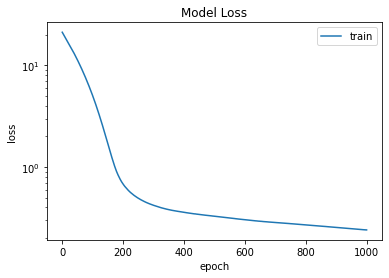

In [30]:
fig = plt.figure()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

## Evaluate test set
Evaluate the test set using the NN and the actual values

In [31]:
test_eval=model(NN_inputs_test,training=False)
test_eval=scaler_out.inverse_transform(test_eval)
test_eval_df=pd.DataFrame(test_eval,columns=results_EUI.columns)

In [32]:
# test_eval_df
# test_out

## Visually Compare the test dataset

In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

In [35]:
mask = test_eval_df.isnull().values.sum(axis=1)==1
print(mask.sum())

0


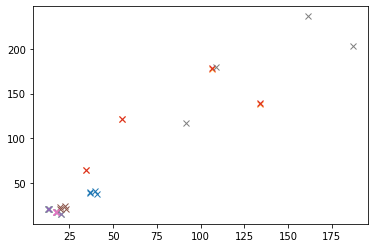

In [36]:
_=[plt.plot(test_out.iloc[:,i], test_eval_df.iloc[:,i],'x') for i in range(num_outputs)]
print()

[-0.86333355 -0.65795201 -2.43322048 -0.66927817 -2.50846502 -0.84428655
  0.         -0.97738051]



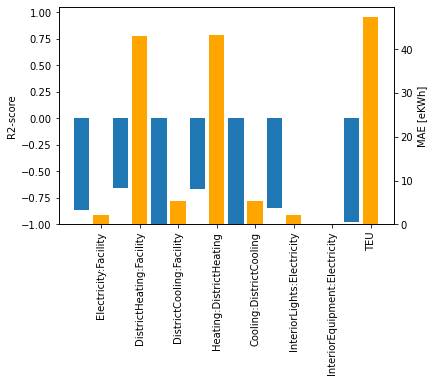

In [37]:
outputs=results_EUI.columns

plt.bar(range(0,len(outputs)*2,2),r2_score(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'))
plt.ylim([-1,1.05])
ax = plt.gca()
ax2=ax.twinx()

ax2.bar(range(1,len(outputs)*2,2),
        mean_absolute_error(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'),
       color='orange')

ax.set_xticks(range(1,len(outputs)*2,2))
_=ax.set_xticklabels(outputs, rotation=90)
ax.set_ylabel('R2-score')
ax2.set_ylabel('MAE [eKWh]')
plt.grid=False
print(r2_score(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'))
print()

In [38]:
results_EUI.columns
end_uses=results_EUI.columns[2:-2]

This plotly chart is an interactive chart that will show the end-use breakdown in bar charts. It compares the results of a NN and the original E+ simulations.

In [39]:
# traces=[]
# buttons=[dict(label = "All",
#                  method = "update",
#                  args = [{"visible": True}])]

# for row in test_eval_df.index.to_list():
#     visibles=[False]*len(test_eval_df.index)
#     visibles[row]=True
    
#     traces.append(
#         go.Bar(
#             x = end_uses,
#             y = test_eval_df.iloc[row][end_uses],
#             name = (f"NN: {row}"),
#             yaxis="y2"
#         ))
    
#     buttons.append(
#     dict(label = str(row),
#                  method = "update",
#                  args = [{"visible": visibles}])
#     )
    
# for row in test_eval_df.index.to_list():
   
#     traces.append(
#         go.Bar(
#             x = end_uses,
#             y = test_out.iloc[row][end_uses],
#             name = (f"E+: {row}"),
#             yaxis="y2"
            
#         ))   
    
# for row in test_eval_df.index.to_list():
   
#     traces.append(
#         go.Table(
#             header=dict(
#                 values=test_in.columns,
#                 font=dict(size=10),
#                 align="left"
#             ),
#             cells=dict(
#                 values=test_in.iloc[row].tolist(),
#                 align = "left")
#         ))    

    
# updatemenus=[dict(active=-1,
#          buttons=buttons)]
    
# layout = dict(title="Dropdown",
#               showlegend=True,
#               xaxis=dict(title="Source"),
#               yaxis=dict(title="Number", range=(-5, test_eval_df[end_uses].max().max()*1.1)),
#               updatemenus=updatemenus,
#               height=600)

# fig = make_subplots(rows=2,cols=1,
#                    row_heights=[.3,.7])
                         
# fig.add_traces(traces)
# fig.update_layout(layout)
# fig.show()

We've noticed that the main parameters affected by this parameter set are the heating:gas, and humidifier:electricity parameters. Let's look at R2 plots for these two parameters

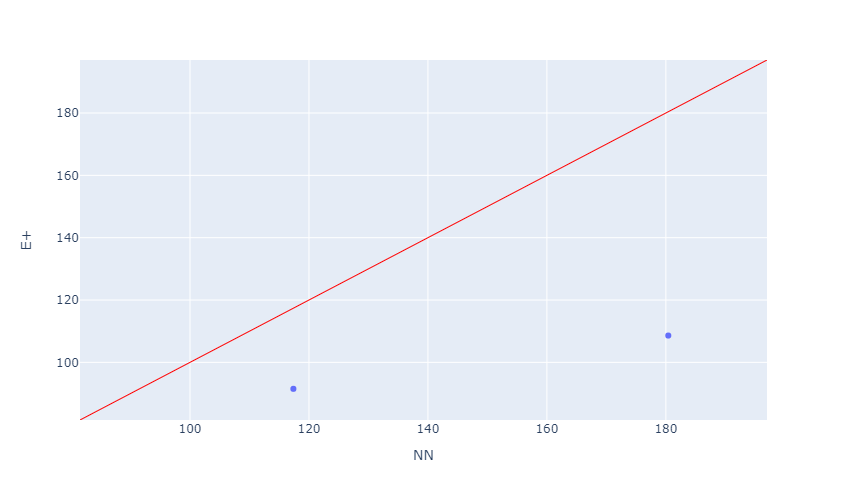

In [40]:
#Scatter subplots of NN vs E+ results

#for now we will do it quickly with express
import plotly.express as px


# traces=[]

# traces.append(
#     go.Scatter(x=test_eval_df['Heating:Gas'],
#               y=test_in['Heating:Gas']))

variable='TEU'
min_range=test_out[variable].min()-10
max_range=test_out[variable].max()+10

fig = px.scatter(x=test_eval_df[variable],y=test_out[variable])
fig.update_layout(
        yaxis=dict(range=[min_range,max_range]),
        xaxis=dict(range=[min_range,max_range]),
        xaxis_title='NN',
        yaxis_title='E+',
        height=500,
        width=500)

fig.add_shape(
        # 1-1 Line
        dict(
            type="line",
            x0=min_range,
            y0=min_range,
            x1=max_range,
            y1=max_range,
            line=dict(
                color="Red",
                width=1
            )))
fig.show()

In [41]:
# #Scatter subplots of NN vs E+ results

# #for now we will do it quickly with express
# import plotly.express as px


# # traces=[]

# # traces.append(
# #     go.Scatter(x=test_eval_df['Heating:Gas'],
# #               y=test_in['Heating:Gas']))

# variable='Cooling:Electricity'
# min_range=test_out[variable].min()-10
# max_range=test_out[variable].max()+10

# fig = px.scatter(x=test_eval_df[variable],y=test_out[variable])
# fig.update_layout(
#         yaxis=dict(range=[min_range,max_range]),
#         xaxis=dict(range=[min_range,max_range]),
#         xaxis_title='NN',
#         yaxis_title='E+',
#         height=500,
#         width=500)

# fig.add_shape(
#         # 1-1 Line
#         dict(
#             type="line",
#             x0=min_range,
#             y0=min_range,
#             x1=max_range,
#             y1=max_range,
#             line=dict(
#                 color="Red",
#                 width=1
#             )))
# fig.show()

# Store metadata

In [42]:
results_EUI.columns=['Electricity:Facility [ekWh/m2]', 'DistrictHeating:Facility [ekWh/m2]',
       'DistrictCooling:Facility [ekWh/m2]', 'Heating:DistrictHeating [ekWh/m2]',
       'Cooling:DistrictCooling [ekWh/m2]', 'InteriorLights:Electricity [ekWh/m2]',
       'InteriorEquipment:Electricity [ekWh/m2]', 'TEU [ekWh/m2]']

In [43]:
inputs_dataframe = inputs_onehot
inputs_index = inputs_onehot.columns
outputs_dataframe = results_EUI
outputs_index = results_EUI.columns
inputs_scaler = scaler_in
outputs_scaler = scaler_out

In [44]:
all_model_metadata = {"inputs_index": inputs_index,
                      "inputs_metadata": inputs_metadata,
                      "model_attributes": model_attributes,
                      "outputs_index": outputs_index,
                      "outputs_metadata": outputs_metadata,
                      "inputs_scaler": inputs_scaler,
                      "outputs_scaler": outputs_scaler,
                      "inputs_dataframe": inputs_dataframe,
                      "outputs_dataframe": outputs_dataframe}

In [45]:
import pickle
pickle.dump(all_model_metadata, open('model_pickle','wb'))

# Store model

In [46]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Tensorflow js model

In [47]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'model_new')

/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning:

The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.



In [48]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)